In [1]:
%pylab inline
from pathlib import Path
import sys
path_to_script =  Path("~/projects/scaffan/").expanduser()
sys.path.insert(0,str(path_to_script))
import scaffan
import scaffan.algorithm
import io3d # just to get data
import scaffan.image as scim
from typing import List
import exsu

import scaffan.slide_segmentation

Populating the interactive namespace from numpy and matplotlib
add path C:\Users\Jirik\Downloads\openslide-win64-20171122\bin


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Example

In [2]:
fn = io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0165_HE.ndpi", get_root=True)
# fn = io3d.datasets.join_path("medical", "orig", "sample_data", "SCP003", "SCP003.ndpi", get_root=True)
# fn = io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0166_HE.ndpi", get_root=True)
print(f"filename: {fn}")

filename: C:/Users/Jirik/data/medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi


In [3]:
# report=None
seg = scaffan.slide_segmentation.SlideSegmentation()
# dir(seg)
anim = scim.AnnotatedImage(fn)
seg.init(anim)
# dir(seg)

2019-10-21 08:43:04.439 | DEBUG    | scaffan.slide_segmentation:__init__:119 - Reading classifier from C:\Users\Jirik\projects\scaffan\scaffan\segmentation_model.pkl
2019-10-21 08:43:04.442 | DEBUG    | scaffan.image:__init__:194 - Reading file C:/Users/Jirik/data/medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi
2019-10-21 08:43:04.448 | DEBUG    | scaffan.image:__init__:208 - Reading the annotation
2019-10-21 08:43:05.377 | DEBUG    | scaffan.annotation:read_annotations:119 - windows annotation output:b'2019-10-21 08:43:05.238 | DEBUG    | scaffan.annotation:ndpa_to_json:71 - PATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\r\n'
2019-10-21 08:43:05.384 | DEBUG    | scaffan.slide_segmentation:_find_best_level:284 - wanted pixelsize mm=[0.01 0.01]
2019-10-21 08:43:05.386 | DEBUG    | scaffan.slide_segmentation:_find_best_level:300 - real pixelsize mm=[0.0072719 0.0072805]


In [15]:

# ann_ids = seg.anim.select_annotations_by_color("#FF0000")
# print(seg.anim.select_annotations_by_color("#000000"))
# print(seg.anim.select_annotations_by_color("#FF0000"))
# print(seg.anim.select_annotations_by_color("#00FF00"))
# print(seg.anim.select_annotations_by_color("#0000FF"))
# print(seg.anim.select_annotations_by_color("#00FFFF"))
# print(seg.anim.select_annotations_by_color("#FF00FF"))
# print(seg.anim.select_annotations_by_color("#FFFF00"))
# print(seg.anim.select_annotations_by_color("#FFFFFF", raise_exception_if_not_found=False))

# Training

In [16]:
# seg.train_svm_classifier()
# seg.save_classifier()

In [17]:
# seg.make_tiles()
# img = seg.tiles[2][2].get_region_image()
# plt.imshow(img)

In [18]:
# fts = seg

In [19]:
# plt.imshow(seg.get_raster_image())

# Features

In [4]:
from scipy.ndimage import gaussian_filter
import skimage
from sklearn.naive_bayes import GaussianNB
import numpy as np
from skimage.feature import peak_local_max
import skimage.filters
from skimage.morphology import disk
import scipy.ndimage
from scipy import stats

def get_features(self, view):
        """
        Three colors and one gaussian smooth reg channel.

        img_sob: gaussian blure applied on gradient sobel operator give information about texture richness in neighborhood

        """
        img = view.get_region_image(as_gray=False)
        print(img.dtype)
        img_gauss2 = gaussian_filter(img[:, :, 0], 2)
        img_gauss5 = gaussian_filter(img[:, :, 0], 5)

        img = np.copy(img)
        imgout = np.zeros([img.shape[0], img.shape[1], 9], dtype=np.uint8)
        img_just_sob = skimage.filters.sobel(img[:, :, 0])
        print(f"just_sob {img_just_sob.dtype} stats: {stats.describe(img_just_sob[:], axis=None)}")
#         img_sob = (np.abs(img_just_sob) * 255).astype(np.uint8)
        img_sob = (np.abs(img_just_sob) * 255).astype(np.uint8)
        print(f"sob {img_sob.dtype} stats: {stats.describe(img_sob[:], axis=None)}")
        img_sob_gauss2 = gaussian_filter(img_sob, 2)
        img_sob_gauss5 = gaussian_filter(img_sob, 5)
        img_sob_median = skimage.filters.median((img_just_sob * 2000).astype(np.uint8), disk(10))

        imgout[:, :, :3] = img[:, :, :3]
        imgout[:, :, 3] = img_gauss2
        imgout[:, :, 4] = img_gauss5
        imgout[:, :, 5] = img_sob
        imgout[:, :, 6] = img_sob_gauss2
        imgout[:, :, 7] = img_sob_gauss5
        imgout[:, :, 8] = img_sob_median
        return imgout

In [53]:
seg.real_pixelsize_mm 

array([0.0072719, 0.0072805])

uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.35622788821616), mean=0.021438372177618743, variance=0.0004190097086773471, skewness=2.1573219653036353, kurtosis=10.723297610649539)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 90), mean=5.003997802734375, variance=27.122285077831442, skewness=2.167676343932836, kurtosis=10.789460220181846)
uint8


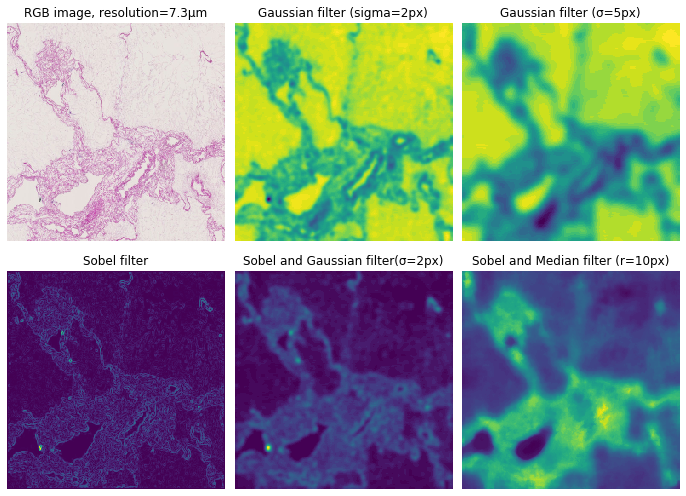

In [79]:

pred = get_features(seg, seg.tiles[2][2])
# pred = mainapp.slide_segmentation._get_features(seg.tiles[2][2])
pred = seg._get_features(seg.tiles[2][2])
fgsh = (2,3)
# fig, axes = plt.subplots(*fgsh)


fig = figure()
plt.subplot(*fgsh, 1)
plt.axis('off')
plt.imshow(pred[:,:,:3])
plt.title(f"RGB image, resolution={seg.real_pixelsize_mm[0]*1000:.1f}μm")
# ax = axes[0, 0]
ax
# ax.imshow(pred[:,:,:3])
# ax.title("RGB image")
# ax.set_title("RGB image")
# ax.axis("off")
# ax.plot([2,3], [5,2])

plt.subplot(*fgsh, 2)
plt.axis('off')
plt.imshow(pred[:,:,3])
plt.title("Gaussian filter (sigma=2px)")

plt.subplot(*fgsh, 3)
plt.axis('off')
plt.imshow(pred[:,:,4])
plt.title("Gaussian filter (σ=5px)")

plt.subplot(*fgsh, 4)
plt.axis('off')
plt.imshow(pred[:,:,5])
plt.title("Sobel filter")

plt.subplot(*fgsh, 5)
plt.axis('off')
plt.imshow(pred[:,:,6])
plt.title("Sobel and Gaussian filter(σ=2px)")

plt.subplot(*fgsh, 6)
plt.axis('off')
plt.imshow(pred[:,:,8])
plt.title("Sobel and Median filter (r=10px)")

plt.tight_layout(h_pad=-13.5, w_pad=-2.5)
# plt.tight_layout(pad=-0.5, w_pad=0.1)

# for i in range(0,pred.shape[2]):
# #     plt.subplot(2,4,i+1)
#     plt.figure(figsize(10,10))
#     plt.imshow(pred[:,:,i])
#     plt.colorbar()

uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.35622788821616), mean=0.021438372177618743, variance=0.0004190097086773471, skewness=2.1573219653036353, kurtosis=10.723297610649539)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 90), mean=5.003997802734375, variance=27.122285077831442, skewness=2.167676343932836, kurtosis=10.789460220181846)
uint8


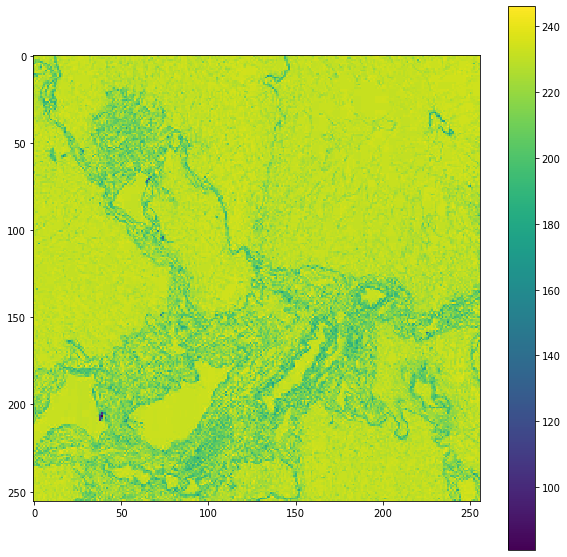

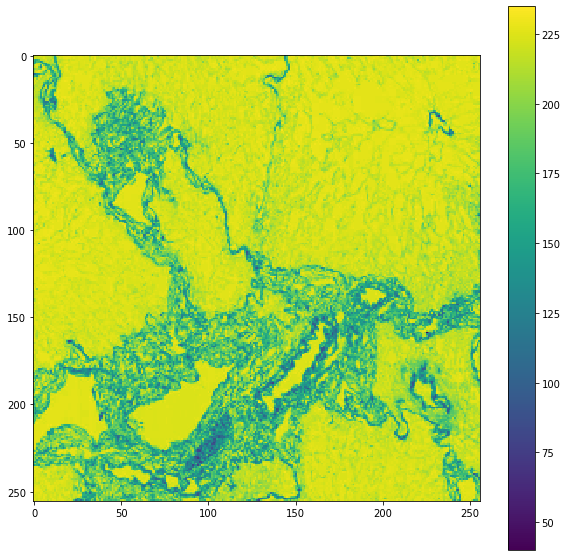

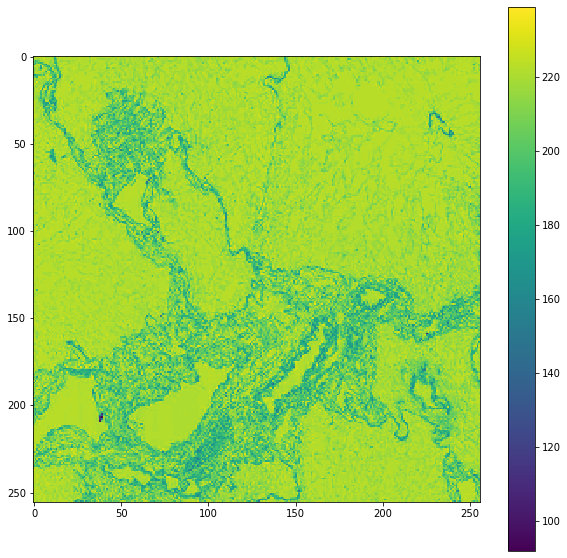

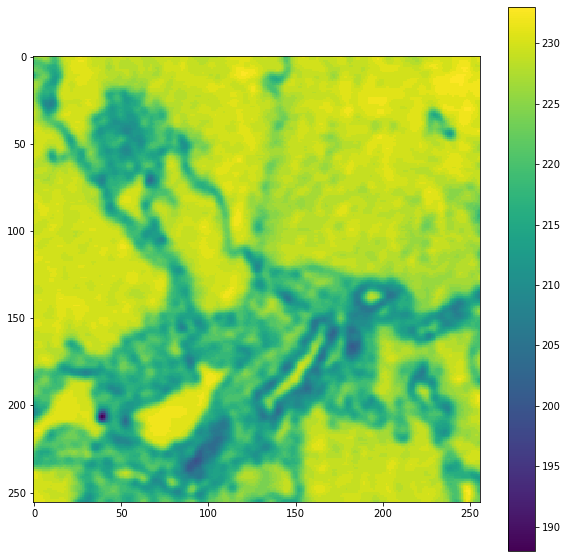

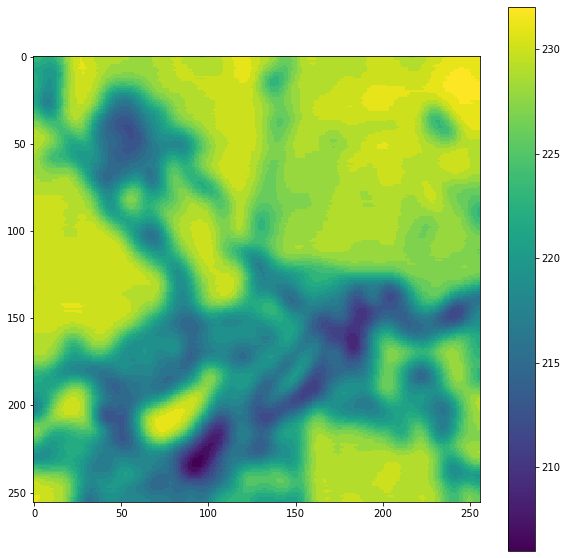

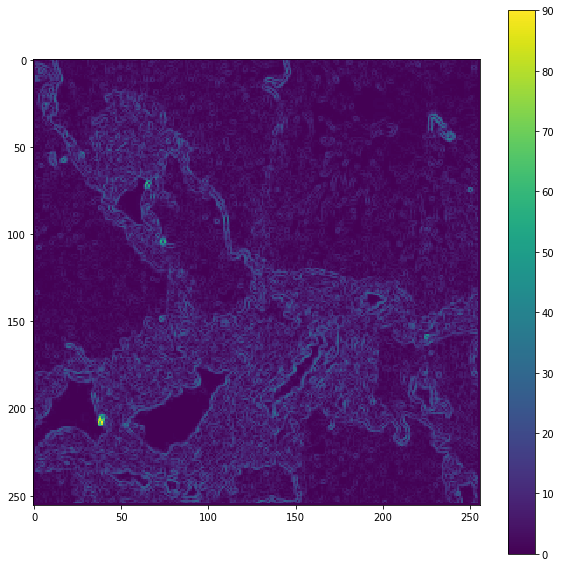

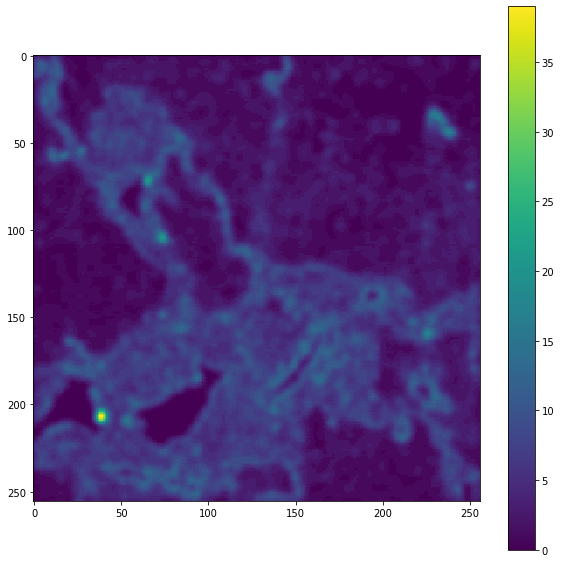

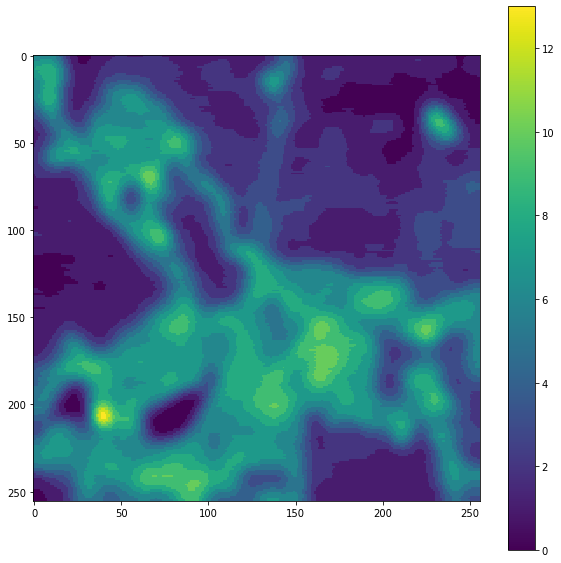

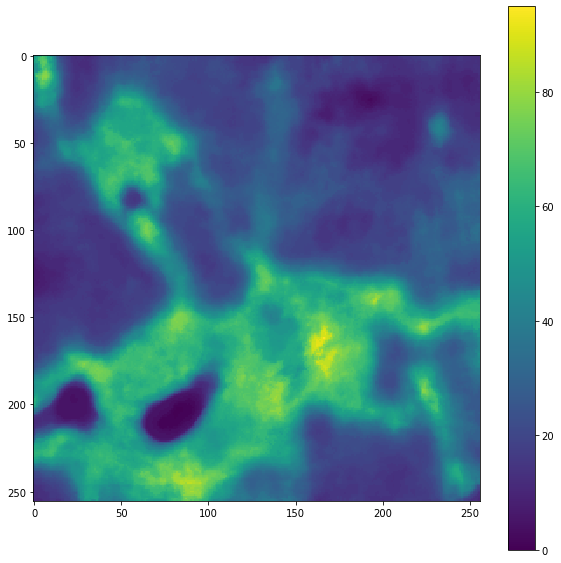

In [10]:

pred = get_features(seg, seg.tiles[2][2])
# pred = mainapp.slide_segmentation._get_features(seg.tiles[2][2])
pred = seg._get_features(seg.tiles[2][2])
# fig, axes = plt.subplots(2, 4)

for i in range(0,pred.shape[2]):
#     plt.subplot(2,4,i+1)
    plt.figure(figsize(10,10))
    plt.imshow(pred[:,:,i])
    plt.colorbar()

# Features experiment

In [22]:
fns_training = [
    io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-002_J-18-0091_HE.ndpi", get_root=True), # training
    io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0165_HE.ndpi", get_root=True), # training
    io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0168_HE.ndpi", get_root=True), # training
    io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0169_HE.ndpi", get_root=True)  # training  bubles
]

fns = [
    io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0166_HE.ndpi", get_root=True),
    io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0167_HE.ndpi", get_root=True),
    io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0169_HE.ndpi", get_root=True)
    # io3d.datasets.join_path("medical", "orig","Scaffan-analysis", "PIG-002_J-18-0091_HE.ndpi", get_root=True),
]


In [31]:
def train_slide_seg(mainapp, fns):
#     mainapp = scaffan.algorithm.Scaffan()
    # if clf_fn is not None:
    #     mainapp.slide_segmentation.clf_fn = Path(clf_fn)
    # clf_fn = Path(mainapp.slide_segmentation.clf_fn)
    clf_fn = mainapp.slide_segmentation.clf_fn
    assert clf_fn.exists()

    for i, fn in enumerate(fns):
            mainapp.set_input_file(fn)
            mainapp.set_output_dir()
            # There does not have to be set some color
            # mainapp.set_annotation_color_selection("#FF00FF")
            # mainapp.set_annotation_color_selection("#FF0000")
#             mainapp.set_annotation_color_selection("#FFFF00")
            mainapp.set_parameter("Input;Automatic Lobulus Selection", True)
            mainapp.set_parameter("Processing;Skeleton Analysis", False)
            mainapp.set_parameter("Processing;Texture Analysis", False)
            mainapp.set_parameter("Processing;Lobulus Segmentation", False)
            if i == 0:
                mainapp.set_parameter("Processing;Slide Segmentation;Clean Before Training", True)
            else:
                mainapp.set_parameter("Processing;Slide Segmentation;Clean Before Training", False)
            mainapp.set_parameter("Processing;Slide Segmentation;Run Training", True)
#             mainapp.set_parameter("Processing;Slide Segmentation;Lobulus Number", 0)
            # mainapp.start_gui(qapp=qapp)
            mainapp.run_lobuluses()

def test_slide_seg(mainapp, fns):
#         mainapp = scaffan.algorithm.Scaffan()
        # if clf_fn is not None:
#         mainapp.slide_segmentation.run()
        #     mainapp.slide_segmentation.clf_fn = Path(clf_fn)
        # clf_fn = Path(mainapp.slide_segmentation.clf_fn)
        clf_fn = mainapp.slide_segmentation.clf_fn
        
        assert clf_fn.exists()
        for fn in fns:
            mainapp.set_input_file(fn)
            mainapp.set_output_dir()
            # There does not have to be set some color
            # mainapp.set_annotation_color_selection("#FF00FF")
            # mainapp.set_annotation_color_selection("#FF0000")
            mainapp.set_annotation_color_selection("#FFFF00")
            mainapp.set_parameter("Input;Automatic Lobulus Selection", True)
            mainapp.set_parameter("Processing;Skeleton Analysis", False)
            mainapp.set_parameter("Processing;Texture Analysis", False)
            mainapp.set_parameter("Processing;Open output dir", False)
            mainapp.set_parameter("Processing;Slide Segmentation;Clean Before Training", False)
            mainapp.set_parameter("Processing;Slide Segmentation;Run Training", False)
            mainapp.set_parameter("Processing;Slide Segmentation;Lobulus Number", 0)
            # mainapp.start_gui(qapp=qapp)
            mainapp.run_lobuluses()

            specimen_size_mm = mainapp.slide_segmentation.sinusoidal_area_mm + mainapp.slide_segmentation.septum_area_mm
            whole_area_mm = mainapp.slide_segmentation.empty_area_mm + specimen_size_mm
#             logger.debug("asserts")
            assert specimen_size_mm  > whole_area_mm * 0.1
            assert mainapp.slide_segmentation.sinusoidal_area_mm > 0.1 * specimen_size_mm
            assert mainapp.slide_segmentation.septum_area_mm > 0.1 * specimen_size_mm



In [32]:

mainapp = scaffan.algorithm.Scaffan()
mainapp.parameters.saveState()

2019-10-19 00:48:06.397 | DEBUG    | scaffan.slide_segmentation:__init__:119 - Reading classifier from C:\Users\Jirik\projects\scaffan\scaffan\segmentation_model.pkl
2019-10-19 00:48:06.416 | DEBUG    | scaffan.algorithm:__init__:69 - common_spreadsheet_file loaded as: C:/Users/Jirik/data/SA_data.xlsx


{'type': 'group',
 'readonly': False,
 'visible': True,
 'enabled': True,
 'renamable': False,
 'removable': False,
 'strictNaming': False,
 'expanded': True,
 'title': None,
 'name': 'params',
 'children': OrderedDict([('Input',
               {'type': 'group',
                'readonly': False,
                'visible': True,
                'enabled': True,
                'renamable': False,
                'removable': False,
                'strictNaming': False,
                'expanded': True,
                'title': None,
                'name': 'Input',
                'children': OrderedDict([('File Path',
                              {'type': 'str',
                               'readonly': False,
                               'visible': True,
                               'enabled': True,
                               'renamable': False,
                               'removable': False,
                               'strictNaming': False,
                        

In [37]:
# mainapp.slide_segmentation._get_features = get_features
mainapp.slide_segmentation.alternative_get_features = get_features
train_slide_seg(mainapp, fns_training)
# logger

2019-10-19 00:56:25.463 | DEBUG    | scaffan.image:__init__:194 - Reading file C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0091_HE.ndpi
2019-10-19 00:56:25.497 | DEBUG    | scaffan.image:__init__:208 - Reading the annotation
2019-10-19 00:56:27.132 | DEBUG    | scaffan.annotation:read_annotations:119 - windows annotation output:b'2019-10-19 00:56:26.981 | DEBUG    | scaffan.annotation:ndpa_to_json:71 - PATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\r\n'
2019-10-19 00:56:27.140 | DEBUG    | scaffan.algorithm:set_input_file:213 - Set Input File Path to : C:/Users/Jirik/data/medical\orig\Scaffan-analysis\PIG-002_J-18-0091_HE.ndpi
2019-10-19 00:56:27.144 | DEBUG    | scaffan.algorithm:set_output_dir:225 - output directory path=C:/Users/Jirik/data/SA_20191019_005627
2019-10-19 00:56:27.146 | DEBUG    | scaffan.algorithm:set_annotation_color_selection:328 - color=#FFFF00
2019-10-19 00:56:27.148 | DEBUG    | scaffan.algorithm:set_annotation_c

uint8
just_sob float64 stats: DescribeResult(nobs=34237, minmax=(0.0, 0.4002041962458795), mean=0.0010488178883359853, variance=3.6443421608202136e-05, skewness=51.97699200140845, kurtosis=3072.2661499336477)
sob uint8 stats: DescribeResult(nobs=34237, minmax=(0, 102), mean=0.06872681601775857, variance=2.2554996437057544, skewness=55.75916883887316, kurtosis=3378.8642667684603)
uint8
just_sob float64 stats: DescribeResult(nobs=67304, minmax=(0.0, 0.12078335879428981), mean=0.0015377847251742329, variance=7.78620099384439e-06, skewness=12.12667626270434, kurtosis=311.0416380101546)
sob uint8 stats: DescribeResult(nobs=67304, minmax=(0, 30), mean=0.1371835254962558, variance=0.3781463606242376, skewness=17.951869592328457, kurtosis=530.6163873277462)
uint8
just_sob float64 stats: DescribeResult(nobs=62878, minmax=(0.0, 0.16813082363507634), mean=0.018993687751863088, variance=0.00034256804817152706, skewness=2.1745594655509564, kurtosis=6.070531216626849)
sob uint8 stats: DescribeResult

2019-10-19 00:56:30.418 | DEBUG    | scaffan.slide_segmentation:train_classifier:153 - cleaning the classifier


uint8
just_sob float64 stats: DescribeResult(nobs=68598, minmax=(0.0, 0.1838673150467033), mean=0.024966245959060215, variance=0.00043250554194062515, skewness=1.3535932014079937, kurtosis=2.0644719127307685)
sob uint8 stats: DescribeResult(nobs=68598, minmax=(0, 46), mean=5.9033791072626025, variance=27.978039808197686, skewness=1.3667274528902273, kurtosis=2.0946944490083332)
uint8
just_sob float64 stats: DescribeResult(nobs=39721, minmax=(0.0, 0.21305209619706603), mean=0.01797477620059106, variance=0.00044510740923501846, skewness=1.6637950221998865, kurtosis=3.1065258659787762)
sob uint8 stats: DescribeResult(nobs=39721, minmax=(0, 54), mean=4.183580473804788, variance=28.304061711606632, skewness=1.7047365101394127, kurtosis=3.252894004854064)
uint8
just_sob float64 stats: DescribeResult(nobs=33294, minmax=(0.0, 0.16386339149628373), mean=0.02256496271284541, variance=0.00047379441588118836, skewness=1.326234109250233, kurtosis=1.6211869004998594)
sob uint8 stats: DescribeResult(

2019-10-19 00:56:30.462 | DEBUG    | scaffan.slide_segmentation:train_classifier:157 - training finished
2019-10-19 00:56:30.464 | DEBUG    | scaffan.slide_segmentation:save_classifier:160 - save clf to C:\Users\Jirik\projects\scaffan\scaffan\segmentation_model.pkl
2019-10-19 00:56:30.468 | DEBUG    | scaffan.slide_segmentation:run:488 - predict...
2019-10-19 00:56:30.469 | DEBUG    | scaffan.slide_segmentation:predict:325 - predict
2019-10-19 00:56:30.470 | DEBUG    | scaffan.slide_segmentation:predict_tiles:312 - predicting tiles


uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.14741134218990193), mean=0.0011632704966205347, variance=5.200607273618098e-06, skewness=24.46222664894238, kurtosis=1294.4805442047054)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 37), mean=0.056182861328125, variance=0.2231042146118844, skewness=43.62329619926741, kurtosis=2835.215630650401)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.15581142793938133), mean=0.0015882921641888366, variance=1.4112556674164006e-05, skewness=17.08771838202886, kurtosis=430.7016340782997)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 39), mean=0.1255035400390625, variance=0.7857592642584682, skewness=20.970988945247125, kurtosis=570.5321441093655)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.15447322150785298), mean=0.002777760154203104, variance=8.32647928592269e-05, skewness=7.3488185739541905, kurtosis=65.4161024149289)
sob uint8 stats: DescribeResult(nobs

uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.6734780355437447), mean=0.01969901460406724, variance=0.0009620554105008195, skewness=10.241238494908615, kurtosis=158.8183917011221)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 171), mean=4.5637054443359375, variance=62.44483146059201, skewness=10.275512094025377, kurtosis=159.5807620374267)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.18447270990509915), mean=0.025707027013347317, variance=0.0004828052879815192, skewness=1.3144147961664365, kurtosis=1.9915127472911385)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 47), mean=6.093017578125, variance=31.17819432125963, skewness=1.3301289632099247, kurtosis=2.029351485182082)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.19028954646952798), mean=0.022913461308050248, variance=0.000416489507352979, skewness=1.3359798055011007, kurtosis=2.1890748158545144)
sob uint8 stats: DescribeResult(nobs=655

sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 46), mean=5.38446044921875, variance=37.71360547068718, skewness=1.8494996868478455, kurtosis=3.8339435172319085)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.1876471612678229), mean=0.029458122184487023, variance=0.0005931015602997601, skewness=1.4137581038726887, kurtosis=2.3745636347692898)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 47), mean=7.0426177978515625, variance=38.43701790631877, skewness=1.4190791313418198, kurtosis=2.3876305460704286)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.21265698003415545), mean=0.012748206458836252, variance=0.0004207966104399351, skewness=2.317019754745964, kurtosis=6.626059649916478)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 54), mean=2.9247894287109375, variance=26.411479165241722, skewness=2.384994530176402, kurtosis=7.0210348250290355)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.24

2019-10-19 00:56:39.145 | DEBUG    | scaffan.slide_segmentation:predict:338 - composing predicted image
2019-10-19 00:56:39.158 | DEBUG    | scaffan.slide_segmentation:_labeling_filtration:359 - labeling filtration


uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.6461014902606492), mean=0.005552674698139739, variance=0.0031678530568343805, skewness=11.21148371408464, kurtosis=123.79578229124006)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 164), mean=1.28680419921875, variance=205.55915508158213, skewness=11.217830159104983, kurtosis=123.89165247839597)


2019-10-19 00:56:39.494 | DEBUG    | scaffan.slide_segmentation:run:490 - evaluate...
2019-10-19 00:56:39.496 | DEBUG    | scaffan.slide_segmentation:evaluate:398 - evaluate
2019-10-19 00:56:39.597 | DEBUG    | exsu.report:imsave:122 - write to file: C:\Users\Jirik\data\SA_20191019_005627\slice_label.png
2019-10-19 00:56:40.271 | DEBUG    | exsu.report:imsave:122 - write to file: C:\Users\Jirik\data\SA_20191019_005627\slice_raster.png
2019-10-19 00:56:42.297 | DEBUG    | scaffan.slide_segmentation:evaluate:410 - real_pixel_size=[0.0072719 0.0072805]
2019-10-19 00:56:42.300 | DEBUG    | scaffan.slide_segmentation:evaluate:414 - empty_area_mm=108.33816404267532
2019-10-19 00:56:42.304 | DEBUG    | exsu.report:set_persistent_cols:42 - Adding persistent cols: ['Slice Empty Area [mm^2]', 'Slice Septum Area [mm^2]', 'Slice Sinusoidal Area [mm^2]']
C:\Users\Jirik\projects\scaffan\scaffan\slide_segmentation.py:434: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr

uint8
just_sob float64 stats: DescribeResult(nobs=101882, minmax=(0.0, 0.21278123845916322), mean=0.019773139598331883, variance=0.0004902547298605157, skewness=1.7403109641730412, kurtosis=3.6042646857051706)
sob uint8 stats: DescribeResult(nobs=101882, minmax=(0, 54), mean=4.626401130719852, variance=31.274140479957893, skewness=1.7796019569608104, kurtosis=3.749431042898971)
uint8
just_sob float64 stats: DescribeResult(nobs=51168, minmax=(0.0, 0.6488744580300082), mean=0.003711325205640058, variance=0.0015681736257938596, skewness=15.813320930132011, kurtosis=253.29344422920883)
sob uint8 stats: DescribeResult(nobs=51168, minmax=(0, 165), mean=0.7642471857410882, variance=101.26900372899713, skewness=15.849370269036294, kurtosis=254.1002957847619)
uint8
just_sob float64 stats: DescribeResult(nobs=179450, minmax=(0.0, 0.2870289548373695), mean=0.013779798870867702, variance=0.0005084979555318431, skewness=2.4253574112677794, kurtosis=7.125060455476293)
sob uint8 stats: DescribeResult

2019-10-19 00:56:52.559 | DEBUG    | scaffan.slide_segmentation:train_classifier:157 - training finished
2019-10-19 00:56:52.562 | DEBUG    | scaffan.slide_segmentation:save_classifier:160 - save clf to C:\Users\Jirik\projects\scaffan\scaffan\segmentation_model.pkl
2019-10-19 00:56:52.567 | DEBUG    | scaffan.slide_segmentation:run:488 - predict...
2019-10-19 00:56:52.569 | DEBUG    | scaffan.slide_segmentation:predict:325 - predict
2019-10-19 00:56:52.571 | DEBUG    | scaffan.slide_segmentation:predict_tiles:312 - predicting tiles



just_sob float64 stats: DescribeResult(nobs=6118, minmax=(0.0, 0.16659167863211408), mean=0.01821364059320844, variance=0.00040538875102808246, skewness=2.2088273299124688, kurtosis=5.672924577244618)
sob uint8 stats: DescribeResult(nobs=6118, minmax=(0, 42), mean=4.197777051323962, variance=26.167188126188982, skewness=2.225068407097571, kurtosis=5.735066248113219)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.05898670179016204), mean=0.0010540439197038096, variance=2.7790570573870362e-06, skewness=5.972402016700393, kurtosis=134.08351962712604)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 15), mean=0.0389556884765625, variance=0.0747927996844333, skewness=20.309395105429754, kurtosis=749.7277571586217)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.32791003398540913), mean=0.0009278231949766833, variance=1.2478953947297523e-05, skewness=66.95172010424625, kurtosis=5543.224593179318)
sob uint8 stats: DescribeResult(nobs=655

uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.3981466579612024), mean=0.016893261110667225, variance=0.000496682055420185, skewness=2.30954278917936, kurtosis=10.023684944044788)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 101), mean=3.91888427734375, variance=31.54517111189989, skewness=2.3654152855983472, kurtosis=10.433122438025833)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.6509575060942797), mean=0.0055153309478999475, variance=0.0032281537916405956, skewness=11.136165700344225, kurtosis=122.31216026858336)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 165), mean=1.3099517822265625, variance=208.79067596624142, skewness=11.14139126952561, kurtosis=122.39075257497349)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.14678733109165765), mean=0.0011062309732664866, variance=4.642656554390925e-06, skewness=26.820276818814076, kurtosis=1529.533593839403)
sob uint8 stats: DescribeResult(nob

2019-10-19 00:56:57.819 | DEBUG    | scaffan.slide_segmentation:predict:338 - composing predicted image
2019-10-19 00:56:57.836 | DEBUG    | scaffan.slide_segmentation:_labeling_filtration:359 - labeling filtration
2019-10-19 00:56:58.110 | DEBUG    | scaffan.slide_segmentation:run:490 - evaluate...
2019-10-19 00:56:58.112 | DEBUG    | scaffan.slide_segmentation:evaluate:398 - evaluate
2019-10-19 00:56:58.208 | DEBUG    | exsu.report:imsave:122 - write to file: C:\Users\Jirik\data\SA_20191019_005647\slice_label.png
2019-10-19 00:56:59.062 | DEBUG    | exsu.report:imsave:122 - write to file: C:\Users\Jirik\data\SA_20191019_005647\slice_raster.png
2019-10-19 00:57:00.048 | DEBUG    | scaffan.slide_segmentation:evaluate:410 - real_pixel_size=[0.0072719 0.0072805]
2019-10-19 00:57:00.049 | DEBUG    | scaffan.slide_segmentation:evaluate:414 - empty_area_mm=79.94165318252573
2019-10-19 00:57:00.050 | DEBUG    | exsu.report:set_persistent_cols:42 - Adding persistent cols: ['Slice Empty Area [

uint8
just_sob float64 stats: DescribeResult(nobs=151803, minmax=(0.0, 0.38249368952937796), mean=0.004149270600837829, variance=0.0002867626058800242, skewness=6.900370681161111, kurtosis=56.27797737954608)
sob uint8 stats: DescribeResult(nobs=151803, minmax=(0, 97), mean=0.8434220667575739, variance=18.099098161452158, skewness=7.023457935951958, kurtosis=58.01926580625181)
uint8
just_sob float64 stats: DescribeResult(nobs=153340, minmax=(0.0, 0.3095618314479793), mean=0.024088110976954943, variance=0.0009699692803849005, skewness=2.0491823757316303, kurtosis=4.876388103727272)
sob uint8 stats: DescribeResult(nobs=153340, minmax=(0, 78), mean=5.745617581844268, variance=62.04634375478515, skewness=2.084445419496329, kurtosis=5.024029912555447)


2019-10-19 00:57:06.589 | DEBUG    | scaffan.slide_segmentation:train_classifier:157 - training finished
2019-10-19 00:57:06.592 | DEBUG    | scaffan.slide_segmentation:save_classifier:160 - save clf to C:\Users\Jirik\projects\scaffan\scaffan\segmentation_model.pkl
2019-10-19 00:57:06.596 | DEBUG    | scaffan.slide_segmentation:run:488 - predict...
2019-10-19 00:57:06.597 | DEBUG    | scaffan.slide_segmentation:predict:325 - predict
2019-10-19 00:57:06.598 | DEBUG    | scaffan.slide_segmentation:predict_tiles:312 - predicting tiles


uint8
just_sob float64 stats: DescribeResult(nobs=37440, minmax=(0.0, 0.188235294117647), mean=0.03240531815128801, variance=0.0008111427069822232, skewness=1.3290509422909143, kurtosis=1.4834171174273623)
sob uint8 stats: DescribeResult(nobs=37440, minmax=(0, 47), mean=7.799572649572649, variance=52.48997016913895, skewness=1.3390915230622724, kurtosis=1.504487622853989)
uint8
just_sob float64 stats: DescribeResult(nobs=20241, minmax=(0.0, 0.26622837395227106), mean=0.037169543944623955, variance=0.0010207731330277167, skewness=1.391716247457929, kurtosis=1.9956392302210206)
sob uint8 stats: DescribeResult(nobs=20241, minmax=(0, 67), mean=9.007707129094412, variance=66.06525680275993, skewness=1.4012283666875398, kurtosis=2.0121380158186755)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.5464400182814145), mean=0.0017760327822232062, variance=0.00022952787955817753, skewness=22.569029000138364, kurtosis=578.0521122765159)
sob uint8 stats: DescribeResult(nobs=6

uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.38249368952937796), mean=0.010250476943230051, variance=0.0005233342496897584, skewness=3.916139455606529, kurtosis=20.449068335140627)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 97), mean=2.3184661865234375, variance=33.09267249898633, skewness=4.001260460930215, kurtosis=21.24658997093422)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.22757349641525734), mean=0.03165573467167226, variance=0.0008777361927604811, skewness=1.705845861814629, kurtosis=3.0457413537373847)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 58), mean=7.6009674072265625, variance=56.946637654175355, skewness=1.7097201529658996, kurtosis=3.061017681973656)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.2673721924085532), mean=0.02816564355322602, variance=0.00084479915812225, skewness=1.724147889591618, kurtosis=3.333017961392623)
sob uint8 stats: DescribeResult(nobs=65536

uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.27861944766416763), mean=0.022430347377400735, variance=0.0009085400104117656, skewness=2.3631987043614338, kurtosis=6.562807340745872)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 71), mean=5.314300537109375, variance=58.26584325225637, skewness=2.396497945915557, kurtosis=6.718244917388688)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.23330037664766987), mean=0.0295933823890625, variance=0.0007785252583371745, skewness=1.6209052912059159, kurtosis=2.639568870659388)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 59), mean=7.0758819580078125, variance=50.50113128897272, skewness=1.623390171347712, kurtosis=2.643716760807531)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.24549967093160815), mean=0.026796982756415517, variance=0.0008949642997524909, skewness=2.2913666465682447, kurtosis=6.290047188382442)
sob uint8 stats: DescribeResult(nobs=6553

uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.25531075816975757), mean=0.01114535869716682, variance=0.0006990332203617884, skewness=3.3604871094842643, kurtosis=12.469242477398426)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 65), mean=2.564361572265625, variance=44.33103719978917, skewness=3.409324886040594, kurtosis=12.821566022387843)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.12540208303626643), mean=0.0010555812836485151, variance=4.354339321623076e-06, skewness=16.822134534746404, kurtosis=798.8208828738348)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 31), mean=0.0698089599609375, variance=0.17330623343524393, skewness=33.35725511780765, kurtosis=2046.0555096578641)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.4103441883847954), mean=0.00110231066970535, variance=2.24665309009719e-05, skewness=57.33844691865463, kurtosis=4136.527200561112)
sob uint8 stats: DescribeResult(nobs=6

2019-10-19 00:57:15.945 | DEBUG    | scaffan.slide_segmentation:predict:338 - composing predicted image
2019-10-19 00:57:15.965 | DEBUG    | scaffan.slide_segmentation:_labeling_filtration:359 - labeling filtration
2019-10-19 00:57:16.425 | DEBUG    | scaffan.slide_segmentation:run:490 - evaluate...
2019-10-19 00:57:16.426 | DEBUG    | scaffan.slide_segmentation:evaluate:398 - evaluate
2019-10-19 00:57:16.570 | DEBUG    | exsu.report:imsave:122 - write to file: C:\Users\Jirik\data\SA_20191019_005703\slice_label.png
2019-10-19 00:57:17.730 | DEBUG    | exsu.report:imsave:122 - write to file: C:\Users\Jirik\data\SA_20191019_005703\slice_raster.png
2019-10-19 00:57:19.325 | DEBUG    | scaffan.slide_segmentation:evaluate:410 - real_pixel_size=[0.0072719 0.0072805]
2019-10-19 00:57:19.327 | DEBUG    | scaffan.slide_segmentation:evaluate:414 - empty_area_mm=128.5055163186742
2019-10-19 00:57:19.328 | DEBUG    | exsu.report:set_persistent_cols:42 - Adding persistent cols: ['Slice Empty Area [

uint8
just_sob float64 stats: DescribeResult(nobs=150490, minmax=(0.0, 0.25411832788579813), mean=0.0059944774639752564, variance=0.00019600875282767236, skewness=5.292212961275711, kurtosis=34.85648060421985)
sob uint8 stats: DescribeResult(nobs=150490, minmax=(0, 64), mean=1.1896139278357365, variance=12.374328798578016, skewness=5.426654991561574, kurtosis=36.243811346976045)


2019-10-19 00:57:26.446 | DEBUG    | scaffan.slide_segmentation:train_classifier:157 - training finished
2019-10-19 00:57:26.448 | DEBUG    | scaffan.slide_segmentation:save_classifier:160 - save clf to C:\Users\Jirik\projects\scaffan\scaffan\segmentation_model.pkl
2019-10-19 00:57:26.452 | DEBUG    | scaffan.slide_segmentation:run:488 - predict...
2019-10-19 00:57:26.454 | DEBUG    | scaffan.slide_segmentation:predict:325 - predict
2019-10-19 00:57:26.455 | DEBUG    | scaffan.slide_segmentation:predict_tiles:312 - predicting tiles


uint8
just_sob float64 stats: DescribeResult(nobs=108800, minmax=(0.0, 0.5385102337175509), mean=0.024684727270611655, variance=0.0005823630355217046, skewness=2.8666379146640044, kurtosis=23.701889984634988)
sob uint8 stats: DescribeResult(nobs=108800, minmax=(0, 137), mean=5.823134191176471, variance=37.7909132550925, skewness=2.87024926953275, kurtosis=23.75846683573499)
uint8
just_sob float64 stats: DescribeResult(nobs=3672, minmax=(0.0, 0.21621370449874794), mean=0.047843593725969885, variance=0.0014455293670310291, skewness=0.9112357473904055, kurtosis=0.519447266340828)
sob uint8 stats: DescribeResult(nobs=3672, minmax=(0, 55), mean=11.751906318082789, variance=93.23099609255611, skewness=0.9310557001156525, kurtosis=0.546541390319915)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.02692064748577642), mean=0.0015283966734353865, variance=5.278401754607008e-06, skewness=2.1728098861198557, kurtosis=6.598856538083833)
sob uint8 stats: DescribeResult(nobs=6

uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.24952473086055862), mean=0.024263592074469886, variance=0.0005905287293384834, skewness=1.9957226441763445, kurtosis=5.014345590760444)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 63), mean=5.732208251953125, variance=38.12308315894983, skewness=2.0116948013282134, kurtosis=5.074630666874953)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.2758580336843097), mean=0.027267115879608568, variance=0.0007123170342146457, skewness=1.852443510425003, kurtosis=5.003730857797578)
sob uint8 stats: DescribeResult(nobs=65536, minmax=(0, 70), mean=6.5037078857421875, variance=45.95686425549347, skewness=1.8725257356135154, kurtosis=5.078204470715541)
uint8
just_sob float64 stats: DescribeResult(nobs=65536, minmax=(0.0, 0.23656722572575783), mean=0.018185352294923227, variance=0.0007820876977112049, skewness=2.1955290141586103, kurtosis=5.247989579539629)
sob uint8 stats: DescribeResult(nobs=65

2019-10-19 00:57:32.027 | DEBUG    | scaffan.slide_segmentation:predict:338 - composing predicted image
2019-10-19 00:57:32.041 | DEBUG    | scaffan.slide_segmentation:_labeling_filtration:359 - labeling filtration
2019-10-19 00:57:32.296 | DEBUG    | scaffan.slide_segmentation:run:490 - evaluate...
2019-10-19 00:57:32.297 | DEBUG    | scaffan.slide_segmentation:evaluate:398 - evaluate
2019-10-19 00:57:32.375 | DEBUG    | exsu.report:imsave:122 - write to file: C:\Users\Jirik\data\SA_20191019_005723\slice_label.png
2019-10-19 00:57:32.972 | DEBUG    | exsu.report:imsave:122 - write to file: C:\Users\Jirik\data\SA_20191019_005723\slice_raster.png
2019-10-19 00:57:34.574 | DEBUG    | scaffan.slide_segmentation:evaluate:410 - real_pixel_size=[0.0072719 0.0072805]
2019-10-19 00:57:34.576 | DEBUG    | scaffan.slide_segmentation:evaluate:414 - empty_area_mm=79.56078048508256
2019-10-19 00:57:34.577 | DEBUG    | exsu.report:set_persistent_cols:42 - Adding persistent cols: ['Slice Empty Area [

In [34]:


test_slide_seg(mainapp, fns)

2019-10-19 00:49:51.453 | DEBUG    | scaffan.image:__init__:194 - Reading file C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0166_HE.ndpi
2019-10-19 00:49:51.498 | DEBUG    | scaffan.image:__init__:208 - Reading the annotation
2019-10-19 00:49:53.461 | DEBUG    | scaffan.annotation:read_annotations:119 - windows annotation output:b'2019-10-19 00:49:53.279 | DEBUG    | scaffan.annotation:ndpa_to_json:71 - PATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\r\n'
2019-10-19 00:49:53.469 | DEBUG    | scaffan.algorithm:set_input_file:213 - Set Input File Path to : C:/Users/Jirik/data/medical\orig\Scaffan-analysis\PIG-003_J-18-0166_HE.ndpi
2019-10-19 00:49:53.477 | DEBUG    | scaffan.algorithm:set_output_dir:225 - output directory path=C:/Users/Jirik/data/SA_20191019_004953
2019-10-19 00:49:53.478 | DEBUG    | scaffan.algorithm:set_annotation_color_selection:328 - color=#FFFF00
2019-10-19 00:49:53.480 | DEBUG    | scaffan.algorithm:set_annotation_c

2019-10-19 00:50:13.558 | DEBUG    | scaffan.annotation:read_annotations:119 - windows annotation output:b'2019-10-19 00:50:13.330 | DEBUG    | scaffan.annotation:ndpa_to_json:71 - PATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\r\n'
2019-10-19 00:50:13.568 | DEBUG    | scaffan.algorithm:init_run:323 - report output dir: C:\Users\Jirik\data\SA_20191019_005011
2019-10-19 00:50:13.570 | DEBUG    | scaffan.slide_segmentation:_find_best_level:250 - wanted pixelsize mm=[0.01 0.01]
2019-10-19 00:50:13.573 | DEBUG    | scaffan.slide_segmentation:_find_best_level:266 - real pixelsize mm=[0.0072719 0.0072805]
2019-10-19 00:50:14.168 | DEBUG    | scaffan.slide_segmentation:run:484 - run...
2019-10-19 00:50:14.169 | DEBUG    | scaffan.slide_segmentation:run:488 - predict...
2019-10-19 00:50:14.170 | DEBUG    | scaffan.slide_segmentation:predict:325 - predict
2019-10-19 00:50:14.172 | DEBUG    | scaffan.slide_segmentation:predict_tiles:312 - predicting tiles
2019-10-

2019-10-19 00:50:49.075 | DEBUG    | scaffan.slide_segmentation:add_biggest_to_annotations:461 - Automatic selection centers_px=[]
2019-10-19 00:50:49.077 | DEBUG    | scaffan.algorithm:run_lobuluses:385 - Annotation IDs: []
2019-10-19 00:50:49.080 | DEBUG    | exsu.report:finish_actual_row:63 - Actual row cols: ['File Name', 'File Path', 'Annotation Color', 'Datetime', 'platform.system', 'platform.node', 'platform.processor', 'Scaffan Version']
2019-10-19 00:50:49.082 | DEBUG    | exsu.report:finish_actual_row:64 - Persistent cols: ['Slice Empty Area [mm^2]', 'Slice Septum Area [mm^2]', 'Slice Sinusoidal Area [mm^2]']
2019-10-19 00:50:49.087 | DEBUG    | exsu.report:finish_actual_row:68 - Unique values types [<map object at 0x0000018A32CA30F0>]
2019-10-19 00:50:49.089 | DEBUG    | scaffan.algorithm:run_lobuluses:402 - Saving dataframe
2019-10-19 00:50:49.091 | DEBUG    | exsu.report:dump:92 - Saving to file C:\Users\Jirik\data\SA_20191019_005035\data.xlsx
2019-10-19 00:50:49.126 | DEB

In [28]:
mainapp.parameters.saveState()

{'type': 'group',
 'readonly': False,
 'visible': True,
 'enabled': True,
 'renamable': False,
 'removable': False,
 'strictNaming': False,
 'expanded': True,
 'title': None,
 'name': 'params',
 'children': OrderedDict([('Input',
               {'type': 'group',
                'readonly': False,
                'visible': True,
                'enabled': True,
                'renamable': False,
                'removable': False,
                'strictNaming': False,
                'expanded': True,
                'title': None,
                'name': 'Input',
                'children': OrderedDict([('File Path',
                              {'type': 'str',
                               'readonly': False,
                               'visible': True,
                               'enabled': True,
                               'renamable': False,
                               'removable': False,
                               'strictNaming': False,
                        